In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai.metrics import error_rate

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
os.listdir("../input/")

['state-farm-distracted-driver-detection']

In [3]:
base_path = "../input/" + os.listdir("../input")[0] + "/"
os.listdir(base_path)

['sample_submission.csv', 'imgs', 'driver_imgs_list.csv']

In [4]:
drivers_df = pd.read_csv(base_path+"driver_imgs_list.csv")

In [5]:
drivers_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
categories = {
"c0": "safe driving",
"c1": "texting - right",
"c2": 'talking on the phone - right',
"c3": "texting - left",
"c4": "talking on the phone - left",
'c5': "operating the radio",
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'
}

In [7]:
??ImageDataBunch.from_folder

In [8]:
imgs_path = base_path + "imgs/"
data = ImageDataBunch.from_folder(imgs_path, train=imgs_path+"train", valid_pct=0.2, test=imgs_path+"test",
                                    ds_tfms=get_transforms(), size=224, bs=16).normalize(imagenet_stats)

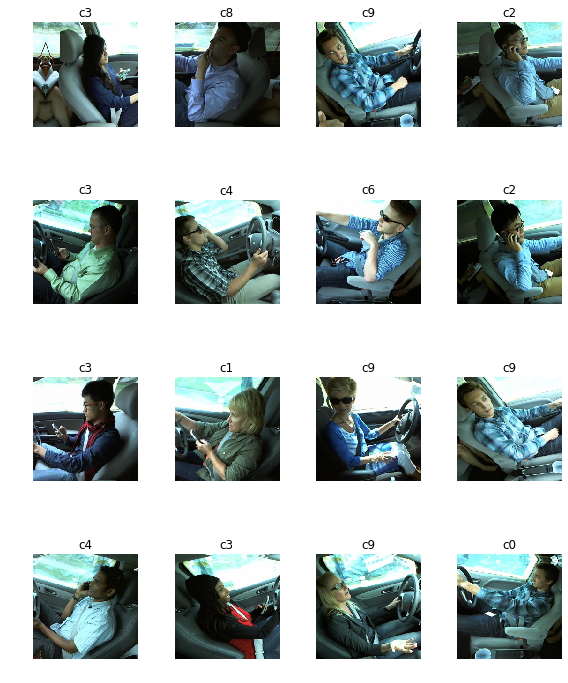

In [9]:
data.show_batch(rows=5, figsize=(8,10))

In [10]:
print(data.classes)
len(data.classes),data.c

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


(10, 10)

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 94.0MB/s]


In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.785589,0.374133,0.116414,07:51
1,0.401912,0.116252,0.033675,07:49
2,0.267677,0.079012,0.023417,07:41
3,0.196143,0.067454,0.020071,08:10


In [14]:
learn.model_dir='/kaggle/working/'

In [15]:
learn.save("stage-1")

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

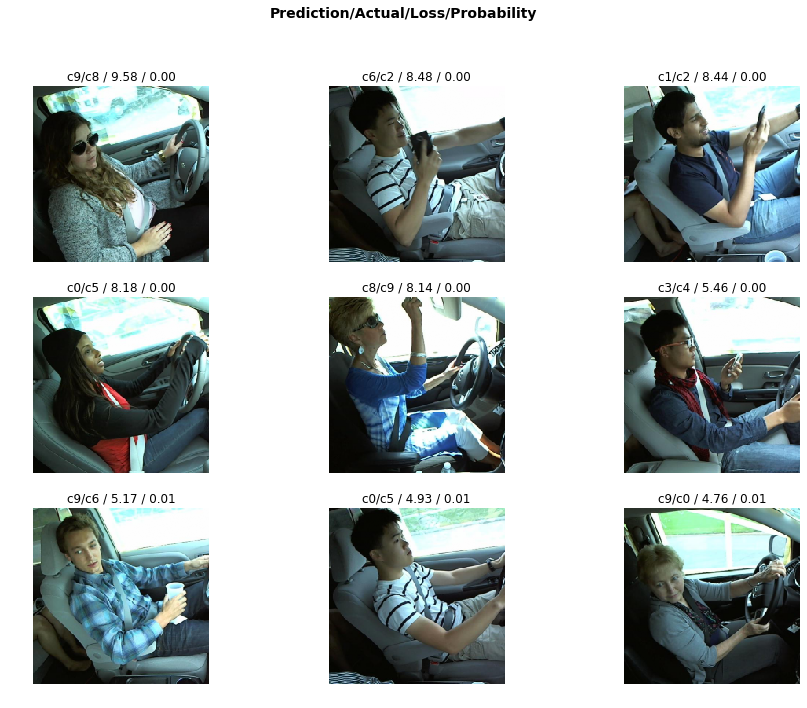

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

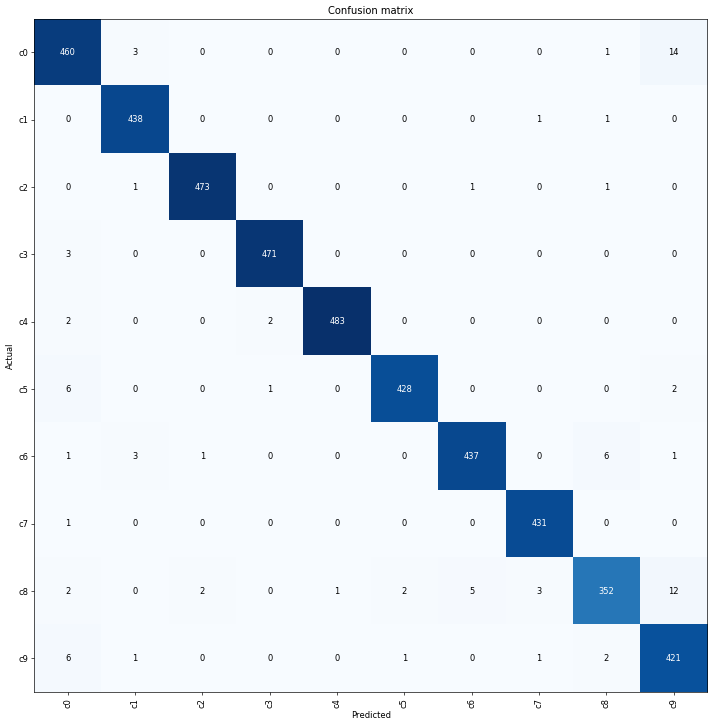

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
confused = interp.most_confused(min_val=2)

In [20]:
for x in confused:
    print("Real:",categories[x[0]],", Predicted:", categories[x[1]],", Number of times it did it:", x[2])

Real: safe driving , Predicted: talking to passenger , Number of times it did it: 14
Real: hair and makeup , Predicted: talking to passenger , Number of times it did it: 12
Real: operating the radio , Predicted: safe driving , Number of times it did it: 6
Real: drinking , Predicted: hair and makeup , Number of times it did it: 6
Real: talking to passenger , Predicted: safe driving , Number of times it did it: 6
Real: hair and makeup , Predicted: drinking , Number of times it did it: 5
Real: safe driving , Predicted: texting - right , Number of times it did it: 3
Real: texting - left , Predicted: safe driving , Number of times it did it: 3
Real: drinking , Predicted: texting - right , Number of times it did it: 3
Real: hair and makeup , Predicted: reaching behind , Number of times it did it: 3
Real: talking on the phone - left , Predicted: safe driving , Number of times it did it: 2
Real: talking on the phone - left , Predicted: texting - left , Number of times it did it: 2
Real: operat

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


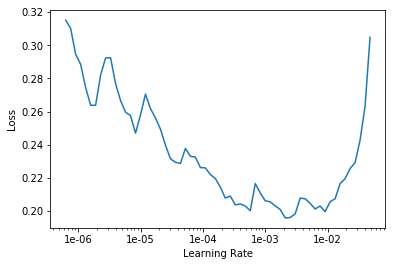

In [22]:
learn.recorder.plot()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.151060,0.060692,0.015388,08:05
1,0.073011,0.031981,0.007583,08:06


In [24]:
learn.save("stage-2")

In [25]:
!pip install pytorch2keras

  Created wheel for pytorch2keras: filename=pytorch2keras-0.2.3-cp36-none-any.whl size=28788 sha256=a078457f1cd52e98a892c95eb76fe746064878409a574670f120f3c6a13d229a
  Stored in directory: /root/.cache/pip/wheels/fd/e8/93/fd5f32f72d2194ba6a95212261dde89c6297e38f8c00e733d3
  Created wheel for onnx2keras: filename=onnx2keras-0.0.17-cp36-none-any.whl size=21411 sha256=854af39db5a6f6114b00a93e4bd0bca6ea252382bcb0791de36ad37fea13e466
  Stored in directory: /root/.cache/pip/wheels/c1/b0/21/08d3ccf566c864f3342698f2c9ad0089a84a1fa33c31615e00
Successfully built pytorch2keras onnx2keras


# Trying to convert Pytorch(fastai) model to keras/tf

In [26]:
!pip install onnx

In [27]:
pytorch_model = learn.model_dir+"stage-2.pth"
keras_output = learn.model_dir+"learn.h5"

In [28]:
import tensorflow as tf
import torch
import onnx

In [29]:
# To Be Continued